In [25]:
# Modelo LSTM
# python3 -m venv env
# source env/bin/activate
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.layers import Input
import joblib
from tensorflow.keras.losses import MeanSquaredError

In [27]:
# Definindo os parâmetros
num_samples = 1000  # Número de amostras
velocidade = np.random.randint(0, 101, num_samples)
velocidade_desejada = np.random.randint(0, 101, num_samples)
felicidade_equipe = np.random.choice([10, 7.5, 5, 2.5], num_samples)
felicidade_cliente = np.random.choice([10, 7.5, 5, 2.5], num_samples)
confianca_entrega = np.random.choice([10, 7.5, 5, 2.5], num_samples)
total_pessoas_equipe = np.random.randint(0, 11, num_samples)
horas_extras = np.random.choice(['sim', 'não'], num_samples)

# Codificação one-hot para horas extras
horas_extras_encoded = pd.get_dummies(horas_extras)

# Criando o DataFrame
data = pd.DataFrame({
    'velocidade': velocidade,
    'velocidade_desejada': velocidade_desejada,
    'felicidade_equipe': felicidade_equipe,
    'felicidade_cliente': felicidade_cliente,
    'confianca_entrega': confianca_entrega,
    'total_pessoas_equipe': total_pessoas_equipe,
    'horas_extras_sim': horas_extras_encoded['sim'],
    'horas_extras_nao': horas_extras_encoded['não']
})

# Exibindo as primeiras linhas do DataFrame
print(data.head())

# Convertendo o DataFrame em um array numpy
data_array = data.to_numpy()
print(data_array[:5])  # Mostrando as primeiras 5 linhas do array para verificação


   velocidade  velocidade_desejada  felicidade_equipe  felicidade_cliente  \
0          18                   95                2.5                10.0   
1          33                   20                5.0                 7.5   
2          11                   76               10.0                 7.5   
3          63                   24                2.5                 5.0   
4          90                   43                5.0                 5.0   

   confianca_entrega  total_pessoas_equipe  horas_extras_sim  horas_extras_nao  
0               10.0                     3             False              True  
1                7.5                     1              True             False  
2                5.0                     2              True             False  
3               10.0                     9             False              True  
4               10.0                     7             False              True  
[[18 95 2.5 10.0 10.0 3 False True]
 [33 20 5.0 7.5

In [28]:
# Escalando os dados
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
print(data_scaled)

[[0.18       0.95       0.         ... 0.3        0.         1.        ]
 [0.33       0.2        0.33333333 ... 0.1        1.         0.        ]
 [0.11       0.76       1.         ... 0.2        1.         0.        ]
 ...
 [0.5        0.08       1.         ... 1.         0.         1.        ]
 [0.         0.39       0.         ... 0.7        0.         1.        ]
 [0.47       0.22       0.         ... 0.5        0.         1.        ]]


In [29]:
# Preparando os dados para o LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        Y.append(data[i + time_step, :])
    return np.array(X), np.array(Y)

# Abu: Testar com 2 ou 3
time_step = 3
X, Y = create_dataset(data_scaled, time_step)

# Verificando as formas dos arrays
print(f'X shape: {X.shape}')  # Esperado: (n_samples, time_steps, n_features)
print(f'Y shape: {Y.shape}')  # Esperado: (n_samples, n_features)

# Reshaping input para [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Dividindo os dados em treinamento e validação
# test_size=0.2 significa 20% para Teste da massa de dados
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


X shape: (996, 3, 8)
Y shape: (996, 8)


In [30]:
# Criando o modelo LSTM otimizado
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(8))  # Ajuste para Qtd de saídas - Array de 4 colunas tem saida de 4 colunas

#model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='adam', loss=MeanSquaredError())


# Resumo do modelo
# model.summary()

/home/abu/Desenvolvimento/Gabriel/env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
# Treinando o modelo
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=64, verbose=0)


In [32]:
# Salvando o modelo treinado no novo formato .keras
model.save('modelo_treinado.keras')

# Salvando o escalador
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [33]:
# Fazendo previsões
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

print("Previsões:")
print(predictions)
print()

# Calculando o MAE, MSE e RMSE
mae = mean_absolute_error(scaler.inverse_transform(Y_val), predictions)
mse = mean_squared_error(scaler.inverse_transform(Y_val), predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
Previsões:
[[51.43373    52.900852    6.902608   ...  5.154772    0.6718507
   0.3471316 ]
 [52.5761     52.052814    6.604391   ...  4.816306    0.49651158
   0.49343556]
 [50.690174   44.446476    6.8730617  ...  5.1759505   0.57835174
   0.3964311 ]
 ...
 [46.50349    46.33928     6.006178   ...  5.6069446   0.44501027
   0.54570436]
 [46.866867   45.834785    6.710926   ...  5.1637087   0.5247065
   0.44205415]
 [50.984486   48.250496    6.570101   ...  5.6137743   0.69174707
   0.30056456]]

Mean Absolute Error (MAE): 7.430439244899898
Mean Squared Error (MSE): 207.28374157972726
Root Mean Squared Error (RMSE): 14.39735189469672


In [34]:
# Convertendo previsões e valores reais para classes (buckets)
def to_class(value, bins):
    return np.digitize(value, bins)

# Definindo intervalos para classificação
bins = [40, 50, 60, 70, 80]
Y_val_classes = np.array([to_class(y, bins) for y in scaler.inverse_transform(Y_val)])
pred_classes = np.array([to_class(y, bins) for y in predictions])

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(Y_val_classes.flatten(), pred_classes.flatten())

print("Matriz de Confusão:")
print(conf_matrix)


Matriz de Confusão:
[[1200   89   65    0    0    0]
 [   0   26   28    0    0    0]
 [   0   25   21    0    0    0]
 [   0   18   16    0    0    0]
 [   0   25   11    0    0    0]
 [   0   44   32    0    0    0]]


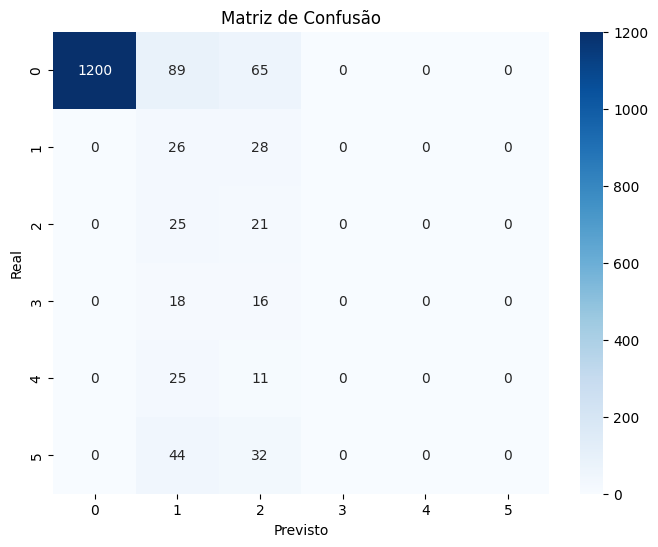

In [35]:
# Plotando a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

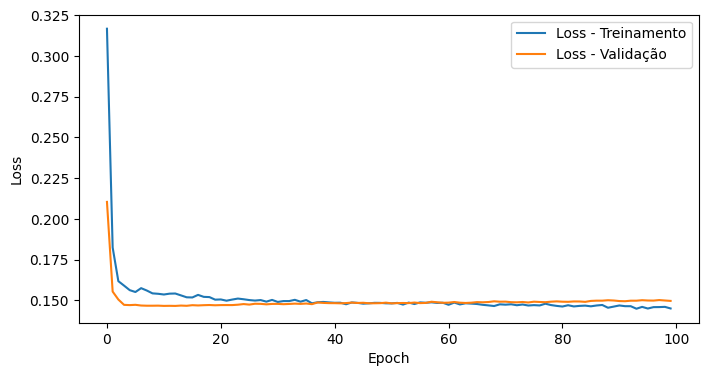

In [36]:
# Plotando o histórico de perda
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Loss - Treinamento')
plt.plot(history.history['val_loss'], label='Loss - Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()